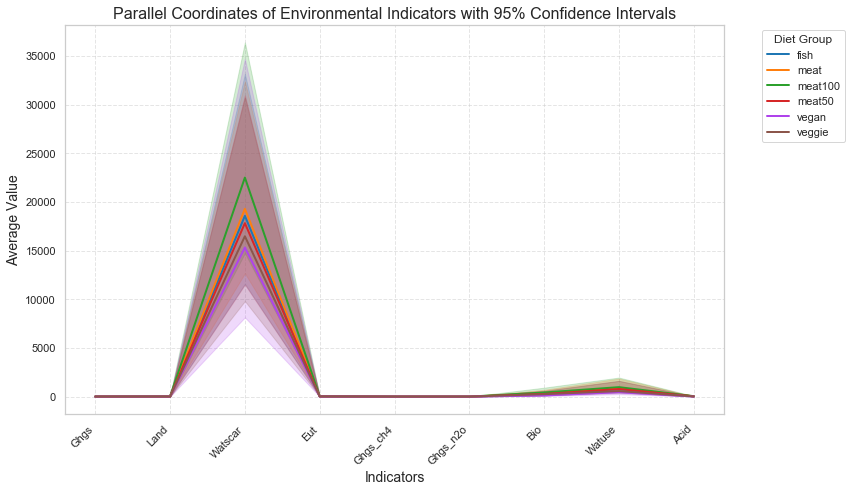

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the dataset
df = pd.read_csv('Results_21Mar2022.csv')

# 2. Identify all mean_* indicator columns
mean_cols = [col for col in df.columns if col.startswith('mean_')]

# 3. Prepare CI summary: mean, low (2.5%), high (97.5%)
summary = (
    df.groupby('diet_group')[mean_cols]
    .agg(['mean', lambda x: x.quantile(0.025), lambda x: x.quantile(0.975)])
    .rename(columns={'<lambda_0>': 'low', '<lambda_1>': 'high'})
)

# 4. Prepare x-axis labels
x_labels = [col.replace('mean_', '').capitalize() for col in mean_cols]
x = range(len(mean_cols))  # 0,1,2,...

# 5. Define colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#af43eb', '#8c564b']

# 6. Plot
plt.figure(figsize=(12, 7))

# For each diet group, plot mean line + CI band
diet_groups = summary.index.tolist()

for idx, diet in enumerate(diet_groups):
    means = summary.loc[diet, (slice(None), 'mean')].values
    lows = summary.loc[diet, (slice(None), 'low')].values
    highs = summary.loc[diet, (slice(None), 'high')].values
    
    # Plot the confidence interval band
    plt.fill_between(x, lows, highs, color=colors[idx], alpha=0.2)
    # Plot the mean line
    plt.plot(x, means, label=diet, color=colors[idx], linewidth=2)

# 7. Beautify the plot
plt.title('Parallel Coordinates of Environmental Indicators with 95% Confidence Intervals', fontsize=16)
plt.xticks(x, x_labels, rotation=45, ha='right')  
plt.xlabel('Indicators', fontsize=14)
plt.ylabel('Average Value', fontsize=14)
plt.legend(title='Diet Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)

# 8. Show the plot
plt.show()



95% intervals for each indicator (columns: median / 2.5th percentile / 97.5th percentile):

            mean_ghgs                        mean_land                        \
               median        low       high     median        low       high   
diet_group                                                                     
fish         5.023311   4.803691   5.452861   6.522492   6.133949   7.053228   
meat         7.535252   6.927746   7.909316  11.683168  10.648742  12.586469   
meat100     11.122742  10.023231  11.839781  17.640315  15.487902  18.958619   
meat50       5.771213   5.331308   6.001415   8.539091   7.889457   9.182604   
vegan        2.556409   2.339626   2.794876   4.428431   4.055278   4.744594   
veggie       4.346307   4.222287   4.752070   6.208630   5.822163   6.476673   

            mean_watscar                               mean_eut  ...  \
                  median           low          high     median  ...   
diet_group                                

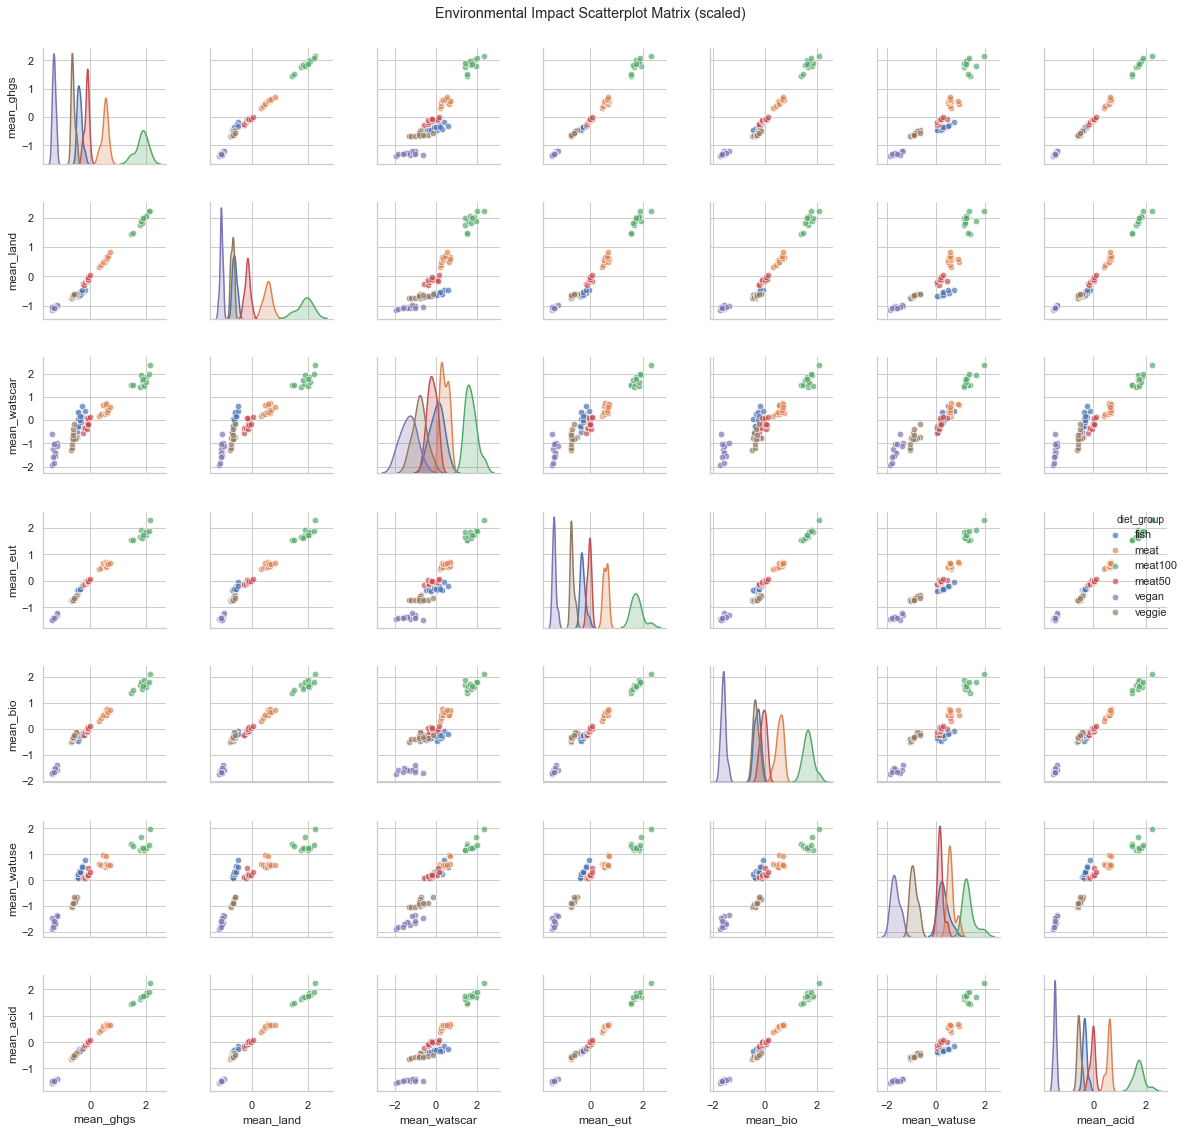


Pearson correlation matrix at the grouping level (72 rows total):
               mean_ghgs  mean_land  mean_watscar  mean_eut  mean_bio  \
mean_ghgs          1.00       0.99          0.95      0.99      0.98   
mean_land          0.99       1.00          0.92      0.98      0.95   
mean_watscar       0.95       0.92          1.00      0.96      0.93   
mean_eut           0.99       0.98          0.96      1.00      0.98   
mean_bio           0.98       0.95          0.93      0.98      1.00   
mean_watuse        0.90       0.85          0.94      0.93      0.92   
mean_acid          0.99       0.97          0.95      1.00      0.99   

              mean_watuse  mean_acid  
mean_ghgs            0.90       0.99  
mean_land            0.85       0.97  
mean_watscar         0.94       0.95  
mean_eut             0.93       1.00  
mean_bio             0.92       0.99  
mean_watuse          1.00       0.93  
mean_acid            0.93       1.00  


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import stats

# ---------- 1. Read and perform "deduplication" ----------
df = pd.read_csv('Results_21Mar2022.csv')

# The "grouping" column uniquely identifies age × gender × diet group.
# The same grouping appears multiple times across 1000 Monte Carlo samples (mc_run_id);
# Take the median for each grouping first, to avoid counting the same population 1000 times.
cols_mean = [
    'mean_ghgs', 'mean_land', 'mean_watscar', 'mean_eut',
    'mean_ghgs_ch4', 'mean_ghgs_n2o', 'mean_bio', 'mean_watuse', 'mean_acid'
]
clean = (df
         .groupby(['diet_group', 'grouping'])[cols_mean]
         .median()
         .reset_index())

# ---------- 2. Generate central estimates and 95% intervals for each diet group ----------
diet_summary = (clean
                .groupby('diet_group')[cols_mean]
                .agg(['median', lambda x: np.percentile(x, 2.5),
                              lambda x: np.percentile(x, 97.5)])
                .rename(columns={'<lambda_0>': 'low', '<lambda_1>': 'high'}))

print("\n95% intervals for each indicator (columns: median / 2.5th percentile / 97.5th percentile):\n")
print(diet_summary)

# ---------- 3. Create a scatterplot matrix (apply StandardScaler for scaling) ----------
features = ['mean_ghgs', 'mean_land', 'mean_watscar',
            'mean_eut', 'mean_bio', 'mean_watuse', 'mean_acid']
scaled = pd.DataFrame(
    StandardScaler().fit_transform(clean[features]),
    columns=features
)
scaled['diet_group'] = clean['diet_group']

sns.set(style="whitegrid")
g = sns.pairplot(
    scaled, hue='diet_group', diag_kind='kde',
    plot_kws=dict(alpha=.7, s=40, edgecolor='w'), height=2.2
)
g.fig.suptitle("Environmental Impact Scatterplot Matrix (scaled)", y=1.02)
plt.tight_layout()
plt.show()

# ---------- 4. Example: Pearson correlation ----------
corr = clean[features].corr()
print("\nPearson correlation matrix at the grouping level (%d rows total):\n" % len(clean), corr.round(2))
